##  **RAG basics using LangChain**

The Code in this Notebook is done following a youtube tutorial, [Learn RAG From Scratch](https://www.youtube.com/watch?v=sVcwVQRHIc8&t=1700s), given by a LangChain Engineer on freeCodeCamp.org and a few medium article, [Retrieval Augmented Generation (RAG) Explained](https://medium.com/@dminhk/retrieval-augmented-generation-rag-explained-b1dd89979681) and [Retrieval-Augmented Generation (RAG) from basics to advanced](https://medium.com/@tejpal.abhyuday/retrieval-augmented-generation-rag-from-basics-to-advanced-a2b068fd576c).

### **Environment**

In [1]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pypika: filename=pypika-0.48.9-py2.py3-none-any.whl size=53914 sha256=bd0608c944a8416a0a7c3e61627bffa80a39e58744bd64f89af5b2db67ced0b3
  Stored in directory: c:\users\jerem\appdata\local\pip\cache\wheels\f7\02\64\d541eac67ec459309d1fb19e727f58ecf7ffb4a8bf42d4cfe5
Successfully built pypika
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 8.7.0
    Uninstalling importlib-metadata-8.7.0:
      Successfully uninstalled importlib-metadata-8.7.0
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.1 requires numpy~=1.19.2, but you have numpy 2.0.2 which is incompatible.
tensorflow 2.6.1 requires typing-extensions~=3.7.4, but you have typing-extensions 4.13.2 which is incompatible.
You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


https://docs.smith.langchain.com/

In [2]:
! pip install bs4

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


In [54]:
from dotenv import load_dotenv
import os 

load_dotenv()

# os.environ.get("langchain_api_key"))
# os.environ.get("openai_api_key"))

False

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = os.environ.get("langchain_api_key"))

In [ ]:
os.environ['OPENAI_API_KEY'] = os.environ.get("openai_api_key"))

### **0. Introduction**

LLMs are trained on a large but fixed corpus of data, limiting their ability to reason about private or recent information. Retrieval augmented generation (RAG) has emerged as a popular and powerful mechanism to expand an LLM's knowledge base, using documents retrieved from an external data source to ground the LLM generation via in-context learning. 

##### **Basic chain vs RAG chain**

Let’s start with a basic chain. A basic chain is composed of a prompt, a model, and an output parser. The basic chain illustrates the core idea of using LLMs in a structured way by defining the input (prompt), the processing step (model), and the output handling (output parser). It serves as a foundational concept that can be extended and combined with other components to build more complex chains and applications.

<div style="text-align: center">

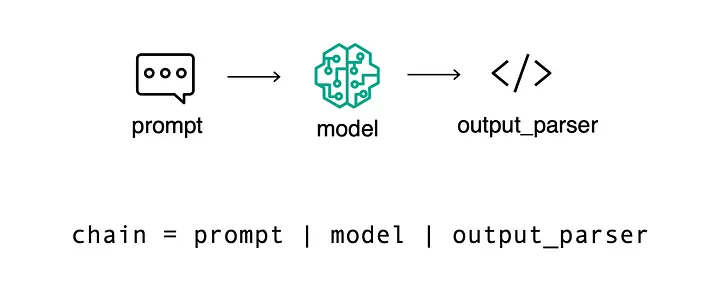

*Figure 1: Basic Chain.*

</div>

Meanwhile, a RAG chain adds context when responding to questions. This is broken down by a RAG prompt, which is a template which provides the users' search query context based on documents stored indexed database storage, a RAG retriever, that prior to constructing the prompt template, retrieves the most relevant documents to the search query and include them as part of the context, and a RAG generator, which would be an LLM, such as OpenAI's ChatGBT.

<div style="text-align: center">

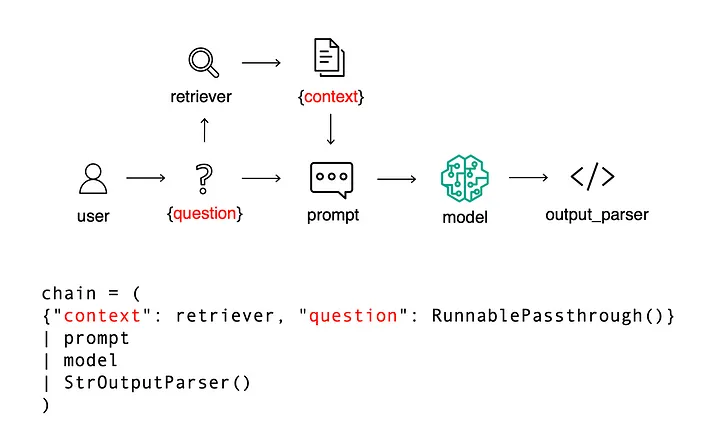

*Figure 2: RAG Chain.*

</div>

Where an example of a typical RAG prompt is given by the below,

<div style="text-align: center">

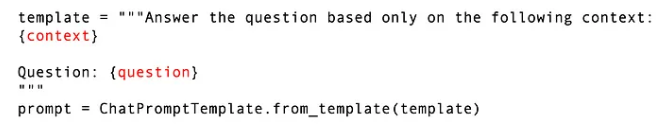

*Figure 3: RAG Prompt.*

</div>

### **1. Indexing**

**Indexing** refers to the process of converting a collection of documents into a searchable format that allows fast and relevant retrieval. This process involves:

1. **Chunking**: Splitting large documents into smaller, semantically meaningful chunks (e.g., paragraphs or sentences).
2. **Embedding**: Encoding each chunk into a fixed-size vector using a text embedding model, such as Sentence Transformers or OpenAI’s embedding models.
3. **Storing**: Saving these vectors in a vector store alongside metadata and original content.

The below Figure illustrates these three key steps,

<div style="text-align: center">

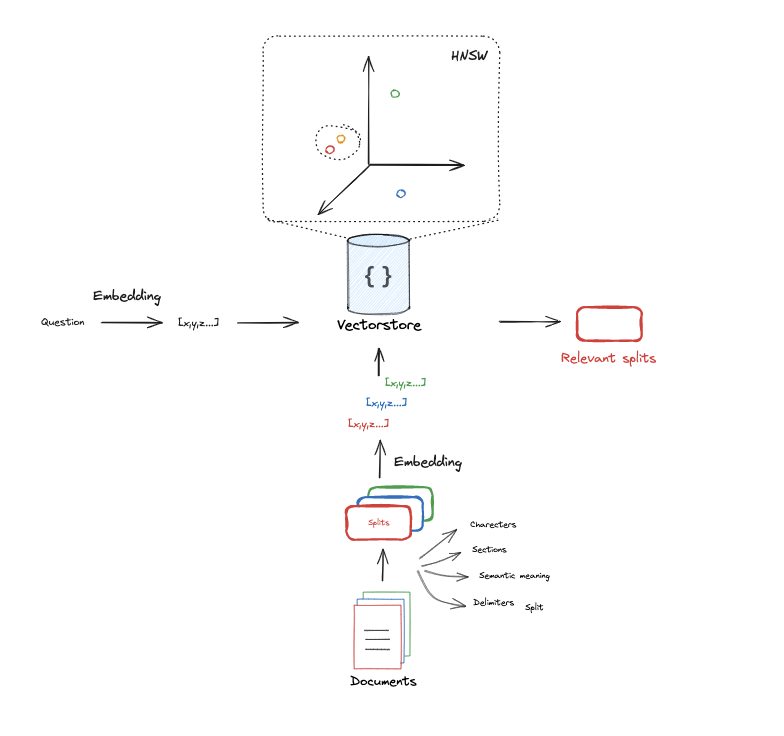

*Figure 4: Indexing.*

</div>

In [5]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS

# Documents
question = "What kinds of pets do I like?"
document = "My favorite pet is a cat."

In [6]:
import tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

num_tokens_from_string(question, "cl100k_base")

8

In [7]:
from langchain_openai import OpenAIEmbeddings
embd = OpenAIEmbeddings()
query_result = embd.embed_query(question)
document_result = embd.embed_query(document)
len(query_result)

1536

In [8]:
# query_result[1:10], document_result[1:10]

In [9]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

similarity = cosine_similarity(query_result, document_result)
print("Cosine Similarity:", similarity)
print("\nWhere a Cosine Similarity of 1 indicates identical match for OpenAI embeddings.")

Cosine Similarity: 0.8806915835035412

Where a Cosine Similarity of 1 indicates identical match for OpenAI embeddings.


##### Loading Documents

[Document Loaders](https://python.langchain.com/docs/integrations/document_loaders/)

In [10]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
blog_docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


##### Splitting Documents

[Text Splitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)

*This text splitter is the recommended one for generic text. It is parameterized by a list of characters. It tries to split on them in order until the chunks are small enough. The default list is ["\n\n", "\n", " ", ""]. This has the effect of trying to keep all paragraphs (and then sentences, and then words) together as long as possible, as those would generically seem to be the strongest semantically related pieces of text.*

In [11]:
# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300, 
    chunk_overlap=50)

# Make splits
splits = text_splitter.split_documents(blog_docs)

In [12]:
# splits 

In [13]:
# Displaying the number of documents and splits
len(blog_docs), len(splits)

(1, 50)

In [14]:
# Displaying the length of the first document and the first split
len(blog_docs[0].page_content), len(splits[0].page_content)

(43047, 969)

In [15]:
# Displaying the first split of the document
splits[0].page_content 

'LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

##### Embedding into Vector Stores

[Vector Stores](https://python.langchain.com/docs/integrations/vectorstores/)

In [16]:
# get the type of splits
print(type(splits))
print(len(splits))
print(type(splits[0]))


<class 'list'>
50
<class 'langchain_core.documents.base.Document'>


In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

### **2. Retrieval**

Once indexed, the vector store enables **retrieval**, the process of finding the most relevant documents based on a user's query. 

During retrieval, the user's unstructured query is first embedded using the same embedding model used during indexing. The system then searches for document vectors in the embedding space that are most similar to the embedded query, typically using a similarity metric such as cosine similarity or dot product. The top matching documents are then returned for use in the RAG prompt to be used in the generation step.


In [ ]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 1}) # k=1 means we want to retrieve the most relevant document

In [21]:
question = "What is Task Decomposition?"

# Get the most relevant document
docs = retriever.get_relevant_documents(question)

# Confirm the number of documents retrieved
print(len(docs))
# Display the most relevant document
print(docs[0].page_content)

4
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.
Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prom

### **3. Generation**

**Generation** then takes the user’s query along with the top matching documents retrieved from the indexed vector store, inserts them into a prompt template, and passes this combined input to a large language model (LLM), such as OpenAI’s ChatGPT, to generate a contextually relevant response.

<div style="text-align: center">

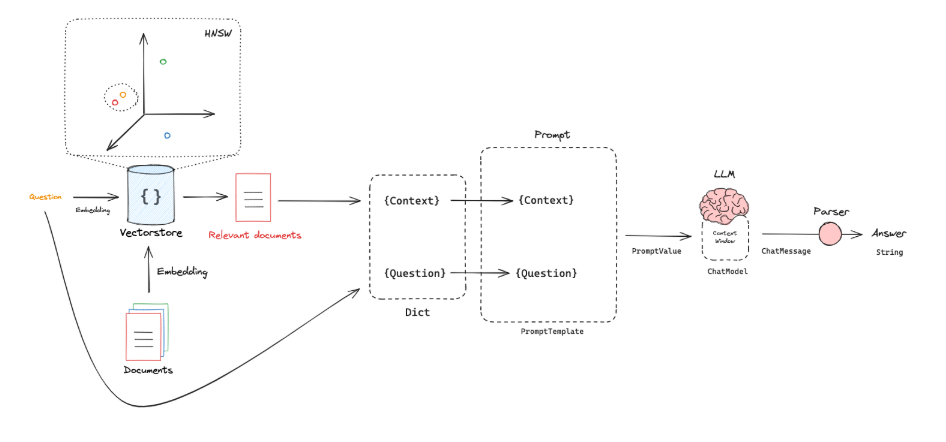

*Figure 5: Generation.*

</div>

In [22]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Prompt
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n{context}\n\nQuestion: {question}\n'), additional_kwargs={})])

In [23]:
# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

In [ ]:
# Chain
chain = prompt | llm # This is LangChain's expression language for chaining together components

In [ ]:
# Run
chain.invoke({"context":docs,"question":"What is Task Decomposition?"}) # This maps the keys in the dictionary to the variables in the prompt template

AIMessage(content='Task Decomposition is a technique used by agents to break down complex tasks into smaller and simpler steps, making them more manageable. This process involves transforming big tasks into multiple smaller tasks, allowing the agent to plan ahead and execute the tasks more effectively.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 961, 'total_tokens': 1010, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BZvXGj4Pk64nw93bg8hQqrTQVdsge', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--2b9b8d7f-cab5-4572-aba2-0d3e674f443b-0', usage_metadata={'input_tokens': 961, 'output_tokens': 49, 'total_tokens': 1010, 'input_token_details': {'audio': 0

In [26]:
# Getting a template of a prompt from LangChain Hub
from langchain import hub
prompt_hub_rag = hub.pull("rlm/rag-prompt")
prompt_hub_rag

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [28]:
# Defining a RAG chain that automatically retrieves the most relevant document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt_hub_rag
    | llm
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task Decomposition is a technique that involves breaking down complex tasks into smaller and simpler steps. This approach allows models to utilize more computation to handle difficult tasks effectively. Task decomposition can be achieved through prompting techniques like Chain of Thought or Tree of Thoughts, which transform big tasks into manageable steps.'

### **4. Query Transformations**

Query transformations are techniques aimed at rewriting or modifying user queries to improve the effectiveness of retrieval. By transfoming the original question, such as, rephrasing, expanding, or decomposing the query into sub-questions, the retrieval hopefully better understands the user’s intent and return more relevant results.

##### **Multi Query**

**Multi-query** refers to generating several differently phrased versions of a user’s question and retrieving documents for each version. The unique set of retrieved documents is then combined and used as context for the prompt template. This approach covers more of the vector space representation, improving the relevance and quality of the context for the language model.

<div style="text-align: center">

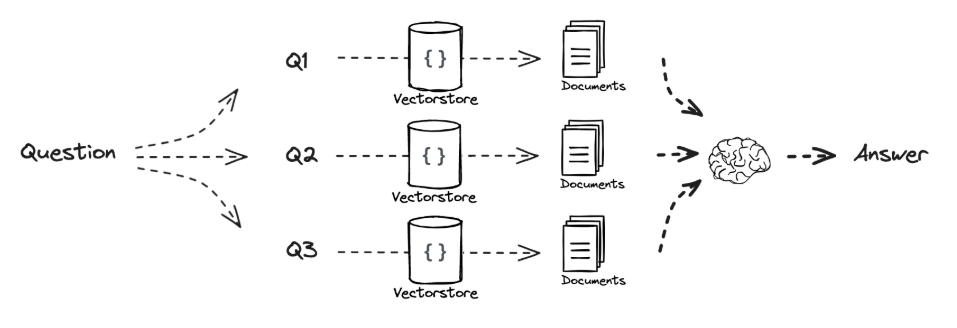

*Figure 6: Multi-Querying.*

</div>

In [29]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [35]:
question = "What is task decomposition for LLM agents?"
generated_queries = generate_queries.invoke({"question": question})

print("Generated Queries:")
for i, q in enumerate(generated_queries, 1):
    print(f"{q}")

Generated Queries:
1. How do LLM agents utilize task decomposition in their operations?
2. Can you explain the concept of task decomposition as applied to LLM agents?
3. In what ways do LLM agents benefit from task decomposition?
4. What role does task decomposition play in the functioning of LLM agents?
5. How is task decomposition integrated into the workflow of LLM agents?


In [36]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

7

In [33]:
from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals to enable efficient handling of complex tasks. This process can be done through techniques like Chain of Thought (CoT) and Tree of Thoughts, as well as using task-specific instructions or human inputs. Task decomposition helps the agent plan ahead and navigate through complicated tasks step by step.'

##### **RAG-Fusion**

Similar to Multi Query, however, the difference is now that in **RAG-Fusion** all the retrieved documents are now ranked (most-to-least relevant). This can be useful when working with multiple vector stores, or when you want to take the top k ranked documents.

<div style="text-align: center">

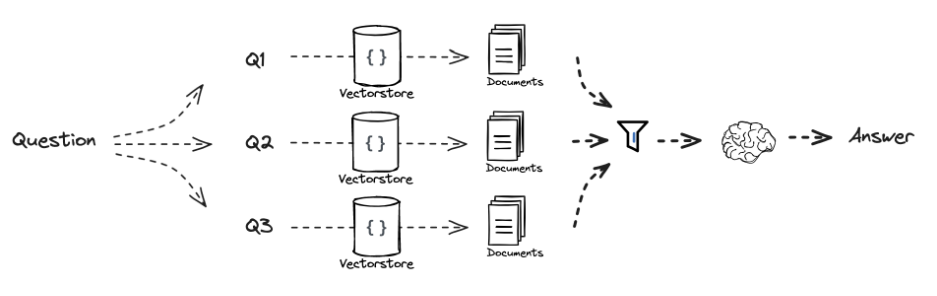

*Figure 7: RAG-Fusion.*

</div>

In [37]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [38]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion 
    | ChatOpenAI(temperature=0)
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)

In [ ]:
from langchain.load import dumps, loads

# We get a list of lists of documents, there are then aggregated into a final fused ranked list of documents
# using the Reciprocal Rank Fusion (RRF) method
def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

7

In [40]:
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals to enable efficient handling of complex tasks. This process allows the agent to plan ahead and think step by step, transforming big tasks into multiple manageable tasks. Task decomposition can be achieved through techniques like Chain of Thought (CoT) and Tree of Thoughts, as well as through simple prompting or task-specific instructions.'

##### **Decomposition**

**Decomposition** is the process of breaking down a complex query into smaller, more manageable sub-questions to improve retrieval and response quality. Two common approaches are:

- **Recursive decomposition**: Intermediate question answer pairs are used as context to guide further decomposition.
- **Answer individually**: Each sub-question is answered independently, and the final response is generated using the collection of question–answer pairs as context.

In [41]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [42]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

In [43]:
questions

['1. What is LLM technology and how does it work in autonomous agent systems?',
 '2. What are the specific components that make up an autonomous agent system powered by LLM?',
 '3. How do the main components of an LLM-powered autonomous agent system interact with each other to enable autonomous behavior?']

**Answer Recursively**

<div style="text-align: center">

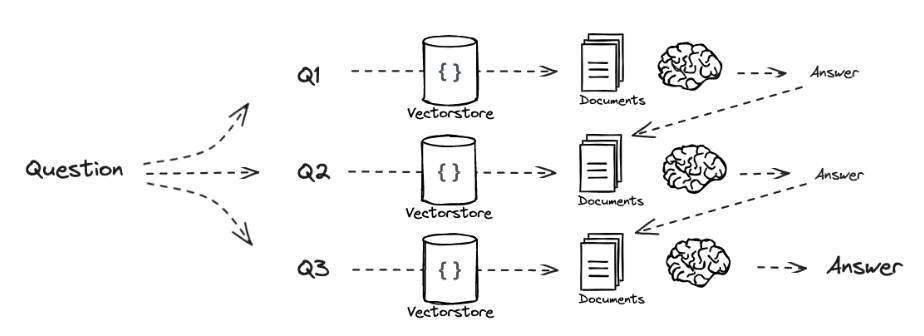

*Figure 7: Recursive Decomposition.*

</div>

In [44]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [45]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [46]:
answer

'The main components of an LLM-powered autonomous agent system interact with each other in a coordinated manner to enable autonomous behavior. \n\n1. Planning: The agent breaks down large tasks into smaller subgoals through subgoal and decomposition. It then reflects on past actions, learns from mistakes, and refines strategies for future steps through self-reflection and refinement. This iterative process allows the agent to improve the quality of its final results.\n\n2. Memory: The agent utilizes short-term memory for in-context learning and long-term memory for retaining and recalling vast amounts of information over extended periods. By leveraging an external vector store for fast retrieval, the agent can access information crucial for decision-making and problem-solving.\n\n3. Tool use: The agent learns to call external APIs for additional information not present in its model weights. By accessing current information, code execution capability, proprietary information sources, an

**Answer Individually**

<div style="text-align: center">

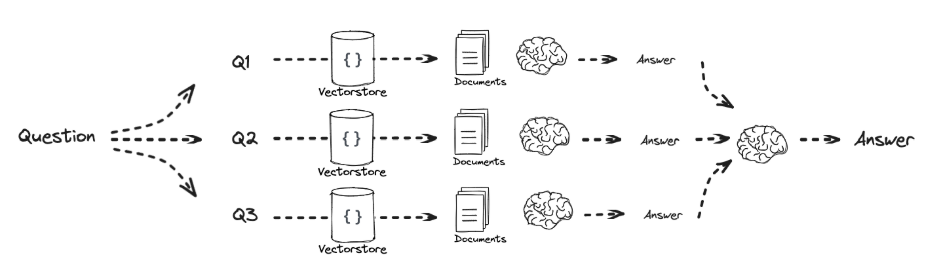

*Figure 7: Non-Recursive Decomposition.*

</div>

In [47]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [48]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system include the LLM technology as the core controller, planning with subgoal decomposition and reflection, memory with short-term and long-term capabilities, and tool use for calling external APIs. These components work together to enable the agent to efficiently handle complex tasks, learn from past actions, and access additional information as needed. The LLM serves as the brain of the agent, with planning, memory, and tool use components supporting its functions in achieving autonomous behavior.'

##### **HyDE**

**HyDE** is a retrieval technique where a language model generates a hypothetical answer or document to the user's question, and this generated text is instead embedded and used to query the vector store. By using a model-generated answer instead of the original query, HyDE can possibly retrieve more relevant documents that better match the kind of response the user is looking for.


<div style="text-align: center">

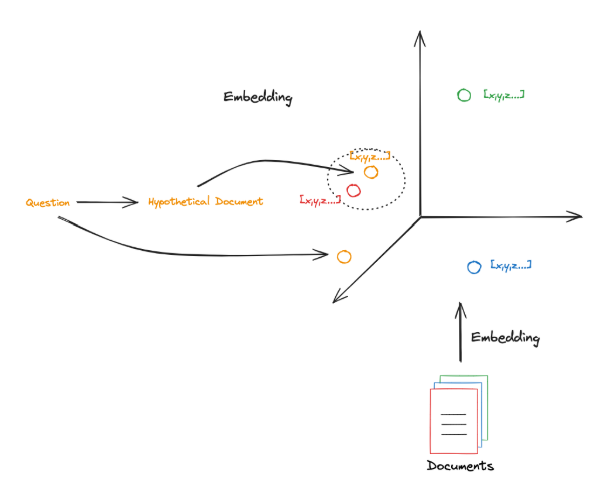

*Figure 7: HyDE.*

</div>

In [49]:
from langchain.prompts import ChatPromptTemplate

# HyDE document genration
template = """Please write a scientific paper passage to answer the question
Question: {question}
Passage:"""
prompt_hyde = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde | ChatOpenAI(temperature=0) | StrOutputParser() 
)

# Run
question = "What is task decomposition for LLM agents?"
generate_docs_for_retrieval.invoke({"question":question})

'Task decomposition is a fundamental concept in the field of reinforcement learning and artificial intelligence, particularly for Large Language Models (LLMs) agents. Task decomposition refers to the process of breaking down a complex task into smaller, more manageable sub-tasks or components. This allows the agent to effectively tackle the overall task by focusing on individual components sequentially or in parallel.\n\nIn the context of LLM agents, task decomposition is crucial for improving the efficiency and effectiveness of the learning process. By breaking down a complex task into smaller sub-tasks, LLM agents can better understand the underlying structure of the task and learn to perform each sub-task more effectively. This can lead to faster learning, improved performance, and better generalization to new tasks.\n\nFurthermore, task decomposition can also help LLM agents to leverage their large-scale language modeling capabilities more effectively. By decomposing a task into sm

In [50]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever 
retireved_docs = retrieval_chain.invoke({"question":question})
retireved_docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a

In [51]:
# RAG
template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":retireved_docs,"question":question})

'Task decomposition for LLM agents involves breaking down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks. This process allows the agent to plan ahead and think step by step, utilizing more test-time computation to decompose hard tasks into smaller and simpler steps. Task decomposition can be done through various techniques such as Chain of Thought, Tree of Thoughts, and using task-specific instructions.'